In [5]:
!pip install --user boto3
!pip install --user pyarrow
!pip install --user fastparquet
!pip install --user minio
!pip install --user mlxtend
!pip install --user pandas

In [6]:
import boto3
import io
import pandas as pd
import os
from minio import Minio
from minio.error import S3Error

In [7]:
# Set your Minio credentials and endpoint
minio_credentials = {
    'region': 'us-east-1',
    'endpoint': 'http://10.183.16.169:9000',
    'use_ssl': False,
    'url_style': 'path',
    'access_key': 'readonly',
    'secret_key': 'readonly'
}

# Create an S3 client
s3 = boto3.client(
    's3',
    region_name=minio_credentials['region'],
    endpoint_url=minio_credentials['endpoint'],
    aws_access_key_id=minio_credentials['access_key'],
    aws_secret_access_key=minio_credentials['secret_key'],
    use_ssl=minio_credentials['use_ssl'],
    config=boto3.session.Config(signature_version='s3v4')
)

# Set the directory to save files
save_directory = './data'

# Create the directory if it doesn't exist
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# List all buckets
response = s3.list_buckets()

# Print each bucket name
print("list of buckets")
for bucket in response['Buckets']:
    print(bucket['Name'])
    objects = s3.list_objects(Bucket=bucket['Name'])
    
    for obj in objects['Contents']:
        print('Downloading ' + obj['Key'])
        
        if os.path.isfile(os.path.join(save_directory, obj['Key'].split('/')[-1] + '.parquet')):
            print(obj['Key'] + ' already exists, skipping...')
            continue

        data = io.BytesIO()
        s3.download_fileobj(bucket['Name'], obj['Key'], data)

        # Save CSV file in the ./data directory
        with open(os.path.join(save_directory, obj['Key'].split('/')[-1]), 'wb') as csv_file:
            csv_file.write(data.getvalue())

        print(obj['Key'] + ' downloaded and saved as CSV in the ./data directory')
        
        # Change the data back to String IO for further processing if needed
        data = io.StringIO(data.getvalue().decode('utf-8'))

        print(obj['Key'] + ' downloaded, now turning it into a parquet file')

        df = pd.read_csv(data)
        df.to_parquet(os.path.join(save_directory, obj['Key'].split('/')[-1] + '.parquet'), index=False)

list of buckets
e-commerce
Divvy Bikes/april_2023.csv already exists, skipping...
Divvy Bikes/august_2022.csv already exists, skipping...
Divvy Bikes/december_2022.csv already exists, skipping...
Divvy Bikes/january_2023.csv downloaded and saved as CSV in the ./data directory
Divvy Bikes/january_2023.csv downloaded, now turning it into a parquet file
Divvy Bikes/july_2022.csv downloaded and saved as CSV in the ./data directory
Divvy Bikes/july_2022.csv downloaded, now turning it into a parquet file
Divvy Bikes/june_2023.csv downloaded and saved as CSV in the ./data directory
Divvy Bikes/june_2023.csv downloaded, now turning it into a parquet file
Divvy Bikes/march_2023.csv downloaded and saved as CSV in the ./data directory
Divvy Bikes/march_2023.csv downloaded, now turning it into a parquet file
Divvy Bikes/may_2023.csv downloaded and saved as CSV in the ./data directory
Divvy Bikes/may_2023.csv downloaded, now turning it into a parquet file
Divvy Bikes/november_2022.csv downloaded an

In [8]:
def upload_parquet_files_to_minio(folder_path, bucket_name, endpoint, access_key, secret_key):
    try:
        # Initialize the Minio client
        minio_client = Minio(endpoint,
                             access_key=access_key,
                             secret_key=secret_key,
                             secure=False)  # Change to True if using HTTPS
        
        # Check if the bucket exists, create it if not
        if not minio_client.bucket_exists(bucket_name):
            minio_client.make_bucket(bucket_name)

        # Loop through files in the specified directory
        for filename in os.listdir(folder_path):
            if filename.endswith(".parquet"):
                file_path = os.path.join(folder_path, filename)
                object_name = filename

                # Upload the parquet file
                minio_client.fput_object(bucket_name, object_name, file_path)

                print(f"File '{object_name}' uploaded successfully to bucket '{bucket_name}' on Minio server.")

    except ReferenceError as e:
        print(f"Error: {e}" +"Too bad!")

# Set your Minio server details
minio_endpoint = "localhost:8000"
minio_access_key = "admin"
minio_secret_key = "password"
minio_bucket_name = "parquets"

# Directory containing parquet files
parquet_folder_path = "./data"

# Call the function
upload_parquet_files_to_minio(parquet_folder_path, minio_bucket_name, minio_endpoint, minio_access_key, minio_secret_key)

File 'april_2023.csv.parquet' uploaded successfully to bucket 'parquets' on Minio server.
File 'august_2022.csv.parquet' uploaded successfully to bucket 'parquets' on Minio server.
File 'dataset.csv.parquet' uploaded successfully to bucket 'parquets' on Minio server.
File 'december_2022.csv.parquet' uploaded successfully to bucket 'parquets' on Minio server.
File 'healthcare_dataset.csv.parquet' uploaded successfully to bucket 'parquets' on Minio server.
File 'heart_attack_prediction_dataset.csv.parquet' uploaded successfully to bucket 'parquets' on Minio server.
File 'january_2023.csv.parquet' uploaded successfully to bucket 'parquets' on Minio server.
File 'july_2022.csv.parquet' uploaded successfully to bucket 'parquets' on Minio server.
File 'june_2023.csv.parquet' uploaded successfully to bucket 'parquets' on Minio server.
File 'march_2023.csv.parquet' uploaded successfully to bucket 'parquets' on Minio server.
File 'may_2023.csv.parquet' uploaded successfully to bucket 'parquets'

In [9]:
# Initialize the Minio client
minio_client = Minio("localhost:8000",
                     access_key="admin",
                     secret_key="password",
                     secure=False)  # Change to True if using HTTPS

# Specify the bucket and file information
bucket_name = "parquets"
file_name = "Online_Retail.csv.parquet"


# Get the Parquet file as an object
obj = minio_client.get_object(bucket_name, file_name)
    
# Read the Parquet file content
parquet_content = obj.read()

# Assuming 'parquet_content' contains the raw Parquet data as bytes
# Read Parquet data using BytesIO
parquet_stream = io.BytesIO(parquet_content)

# Read the Parquet data using pandas
df = pd.read_parquet(parquet_stream)

# Now you can work with the DataFrame 'df' containing your Parquet data
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [10]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [11]:
df.Country.unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [12]:
# Stripping extra spaces in the description 
df['Description'] = df['Description'].str.strip() 
  
# Dropping the rows without any invoice number 
df.dropna(axis = 0, subset =['InvoiceNo'], inplace = True) 
df['InvoiceNo'] = df['InvoiceNo'].astype('str') 
  
# Dropping all transactions which were done on credit 
df = df[~df['InvoiceNo'].str.contains('C')] 

In [13]:
# Transactions done in France 
basket_France = (df[df['Country'] =="France"] 
          .groupby(['InvoiceNo', 'Description'])['Quantity'] 
          .sum().unstack().reset_index().fillna(0) 
          .set_index('InvoiceNo')) 
  
# Transactions done in the United Kingdom 
basket_UK = (df[df['Country'] =="United Kingdom"] 
          .groupby(['InvoiceNo', 'Description'])['Quantity'] 
          .sum().unstack().reset_index().fillna(0) 
          .set_index('InvoiceNo')) 
  
# Transactions done in Portugal 
basket_Por = (df[df['Country'] =="Portugal"] 
          .groupby(['InvoiceNo', 'Description'])['Quantity'] 
          .sum().unstack().reset_index().fillna(0) 
          .set_index('InvoiceNo')) 
  
basket_Sweden = (df[df['Country'] =="Sweden"] 
          .groupby(['InvoiceNo', 'Description'])['Quantity'] 
          .sum().unstack().reset_index().fillna(0) 
          .set_index('InvoiceNo')) 

In [14]:
# Defining the hot encoding function to make the data suitable  
# for the concerned libraries 
def hot_encode(x): 
    if(x<= 0): 
        return 0
    if(x>= 1): 
        return 1
  
# Encoding the datasets 
basket_encoded = basket_France.applymap(hot_encode) 
basket_France = basket_encoded 
  
basket_encoded = basket_UK.applymap(hot_encode) 
basket_UK = basket_encoded 
  
basket_encoded = basket_Por.applymap(hot_encode) 
basket_Por = basket_encoded 
  
basket_encoded = basket_Sweden.applymap(hot_encode) 
basket_Sweden = basket_encoded 

C:\Users\HP\AppData\Local\Temp\ipykernel_23048\4278043946.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_encoded = basket_France.applymap(hot_encode)
C:\Users\HP\AppData\Local\Temp\ipykernel_23048\4278043946.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_encoded = basket_UK.applymap(hot_encode)
C:\Users\HP\AppData\Local\Temp\ipykernel_23048\4278043946.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_encoded = basket_Por.applymap(hot_encode)
C:\Users\HP\AppData\Local\Temp\ipykernel_23048\4278043946.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_encoded = basket_Sweden.applymap(hot_encode)


In [18]:
from mlxtend.frequent_patterns import apriori, association_rules

In [20]:
# Building the model 
frq_items = apriori(basket_France, min_support = 0.05, use_colnames = True) 
  
# Collecting the inferred rules in a dataframe 
rules = association_rules(frq_items, metric ="lift", min_threshold = 1) 
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False]) 
rules 

C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
44,(JUMBO BAG WOODLAND ANIMALS),(POSTAGE),0.076531,0.765306,0.076531,1.000000,1.306667,0.017961,inf,0.254144
260,"(RED TOADSTOOL LED NIGHT LIGHT, PLASTERS IN TI...",(POSTAGE),0.051020,0.765306,0.051020,1.000000,1.306667,0.011974,inf,0.247312
270,"(PLASTERS IN TIN WOODLAND ANIMALS, RED TOADSTO...",(POSTAGE),0.053571,0.765306,0.053571,1.000000,1.306667,0.012573,inf,0.247978
301,"(SET/20 RED RETROSPOT PAPER NAPKINS, SET/6 RED...",(SET/6 RED SPOTTY PAPER PLATES),0.102041,0.127551,0.099490,0.975000,7.644000,0.086474,34.897959,0.967949
300,"(SET/20 RED RETROSPOT PAPER NAPKINS, SET/6 RED...",(SET/6 RED SPOTTY PAPER CUPS),0.102041,0.137755,0.099490,0.975000,7.077778,0.085433,34.489796,0.956294
...,...,...,...,...,...,...,...,...,...,...
36,(POSTAGE),(JAM MAKING SET PRINTED),0.765306,0.053571,0.051020,0.066667,1.244444,0.010022,1.014031,0.836957
27,(POSTAGE),(CIRCUS PARADE CHILDRENS EGG CUP),0.765306,0.056122,0.051020,0.066667,1.187879,0.008070,1.011297,0.673913
96,(POSTAGE),(PARTY BUNTING),0.765306,0.056122,0.051020,0.066667,1.187879,0.008070,1.011297,0.673913
225,(POSTAGE),"(LUNCH BAG WOODLAND, LUNCH BAG RED RETROSPOT)",0.765306,0.056122,0.051020,0.066667,1.187879,0.008070,1.011297,0.673913


In [22]:
frq_items = apriori(basket_Por, min_support = 0.05, use_colnames = True) 
rules = association_rules(frq_items, metric ="lift", min_threshold = 1) 
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False]) 
rules 

C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
1170,(SET 12 COLOUR PENCILS SPACEBOY),(SET 12 COLOUR PENCILS DOLLY GIRL),0.051724,0.051724,0.051724,1.0,19.333333,0.049049,inf,1.000000
1171,(SET 12 COLOUR PENCILS DOLLY GIRL),(SET 12 COLOUR PENCILS SPACEBOY),0.051724,0.051724,0.051724,1.0,19.333333,0.049049,inf,1.000000
1172,(SET OF 4 KNICK KNACK TINS LONDON),(SET 12 COLOUR PENCILS DOLLY GIRL),0.051724,0.051724,0.051724,1.0,19.333333,0.049049,inf,1.000000
1173,(SET 12 COLOUR PENCILS DOLLY GIRL),(SET OF 4 KNICK KNACK TINS LONDON),0.051724,0.051724,0.051724,1.0,19.333333,0.049049,inf,1.000000
1174,(SET OF 4 KNICK KNACK TINS POPPIES),(SET 12 COLOUR PENCILS DOLLY GIRL),0.051724,0.051724,0.051724,1.0,19.333333,0.049049,inf,1.000000
...,...,...,...,...,...,...,...,...,...,...
1056,(POSTAGE),(REGENCY CAKESTAND 3 TIER),0.517241,0.086207,0.051724,0.1,1.160000,0.007134,1.015326,0.285714
1059,(POSTAGE),(RETROSPOT HEART HOT WATER BOTTLE),0.517241,0.086207,0.051724,0.1,1.160000,0.007134,1.015326,0.285714
1066,(POSTAGE),(SET OF 3 CAKE TINS PANTRY DESIGN),0.517241,0.086207,0.051724,0.1,1.160000,0.007134,1.015326,0.285714
1070,(POSTAGE),(SET OF 36 TEATIME PAPER DOILIES),0.517241,0.086207,0.051724,0.1,1.160000,0.007134,1.015326,0.285714


In [23]:
frq_items = apriori(basket_Sweden, min_support = 0.05, use_colnames = True) 
rules = association_rules(frq_items, metric ="lift", min_threshold = 1) 
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False]) 
rules 

C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(PACK OF 72 SKULL CAKE CASES),(12 PENCILS SMALL TUBE SKULL),0.055556,0.055556,0.055556,1.000000,18.000000,0.052469,inf,1.000000
1,(12 PENCILS SMALL TUBE SKULL),(PACK OF 72 SKULL CAKE CASES),0.055556,0.055556,0.055556,1.000000,18.000000,0.052469,inf,1.000000
4,(ASSORTED BOTTLE TOP MAGNETS),(36 DOILIES DOLLY GIRL),0.055556,0.055556,0.055556,1.000000,18.000000,0.052469,inf,1.000000
5,(36 DOILIES DOLLY GIRL),(ASSORTED BOTTLE TOP MAGNETS),0.055556,0.055556,0.055556,1.000000,18.000000,0.052469,inf,1.000000
180,(CHILDRENS CUTLERY CIRCUS PARADE),(CHILDRENS CUTLERY DOLLY GIRL),0.055556,0.055556,0.055556,1.000000,18.000000,0.052469,inf,1.000000
...,...,...,...,...,...,...,...,...,...,...
25486,(POSTAGE),"(CHILDRENS CUTLERY CIRCUS PARADE, CHILDRENS CU...",0.611111,0.055556,0.055556,0.090909,1.636364,0.021605,1.038889,1.000000
202,(POSTAGE),(CUPCAKE LACE PAPER SET 6),0.611111,0.083333,0.055556,0.090909,1.090909,0.004630,1.008333,0.214286
384,(POSTAGE),(MINI PLAYING CARDS DOLLY GIRL),0.611111,0.083333,0.055556,0.090909,1.090909,0.004630,1.008333,0.214286
482,(POSTAGE),(ROUND SNACK BOXES SET OF4 WOODLAND),0.611111,0.083333,0.055556,0.090909,1.090909,0.004630,1.008333,0.214286


In [59]:
# Initialize the Minio client
minio_client = Minio("localhost:8000",
                     access_key="admin",
                     secret_key="password",
                     secure=False)  # Change to True if using HTTPS

# Specify the bucket and file information
bucket_name = "parquets"
file_name = "heart_attack_prediction_dataset.csv.parquet"


# Get the Parquet file as an object
obj = minio_client.get_object(bucket_name, file_name)
    
# Read the Parquet file content
parquet_content = obj.read()

# Assuming 'parquet_content' contains the raw Parquet data as bytes
# Read Parquet data using BytesIO
parquet_stream = io.BytesIO(parquet_content)

# Read the Parquet data using pandas
df2 = pd.read_parquet(parquet_stream)

# Now you can work with the DataFrame 'df' containing your Parquet data
df2

,Patient ID,Age,Sex,Cholesterol,Blood Pressure,Heart Rate,Diabetes,Family History,Smoking,Obesity,...,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk
0,BMW7812,67,Male,208,158/88,72,0,0,1,0,...,6.615001,261404,31.251233,286,0,6,Argentina,South America,Southern Hemisphere,0
1,CZE1114,21,Male,389,165/93,98,1,1,1,1,...,4.963459,285768,27.194973,235,1,7,Canada,North America,Northern Hemisphere,0
2,BNI9906,21,Female,324,174/99,72,1,0,0,0,...,9.463426,235282,28.176571,587,4,4,France,Europe,Northern Hemisphere,0
3,JLN3497,84,Male,383,163/100,73,1,1,1,0,...,7.648981,125640,36.464704,378,3,4,Canada,North America,Northern Hemisphere,0
4,GFO8847,66,Male,318,91/88,93,1,1,1,1,...,1.514821,160555,21.809144,231,1,5,Thailand,Asia,Northern Hemisphere,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8758,MSV9918,60,Male,121,94/76,61,1,1,1,0,...,10.806373,235420,19.655895,67,7,7,Thailand,Asia,Northern Hemisphere,0
8759,QSV6764,28,Female,120,157/102,73,1,0,0,1,...,3.833038,217881,23.993866,617,4,9,Canada,North America,Northern Hemisphere,0
8760,XKA5925,47,Male,250,161/75,105,0,1,1,1,...,2.375214,36998,35.406146,527,4,4,Brazil,South America,Southern Hemisphere,1
8761,EPE6801,36,Male,178,119/67,60,1,0,1,0,...,0.029104,209943,27.294020,114,2,8,Brazil,South America,Southern Hemisphere,0


In [25]:
df2.columns

Index(['Patient ID', 'Age', 'Sex', 'Cholesterol', 'Blood Pressure',
       'Heart Rate', 'Diabetes', 'Family History', 'Smoking', 'Obesity',
       'Alcohol Consumption', 'Exercise Hours Per Week', 'Diet',
       'Previous Heart Problems', 'Medication Use', 'Stress Level',
       'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides',
       'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Country',
       'Continent', 'Hemisphere', 'Heart Attack Risk'],
      dtype='object')

In [26]:
df2.isna().sum()

Patient ID                         0
Age                                0
Sex                                0
Cholesterol                        0
Blood Pressure                     0
Heart Rate                         0
Diabetes                           0
Family History                     0
Smoking                            0
Obesity                            0
Alcohol Consumption                0
Exercise Hours Per Week            0
Diet                               0
Previous Heart Problems            0
Medication Use                     0
Stress Level                       0
Sedentary Hours Per Day            0
Income                             0
BMI                                0
Triglycerides                      0
Physical Activity Days Per Week    0
Sleep Hours Per Day                0
Country                            0
Continent                          0
Hemisphere                         0
Heart Attack Risk                  0
dtype: int64

In [29]:
!pip install yellowbrick
!pip install scikit-learn

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import yellowbrick
from yellowbrick.style import set_palette
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import DBSCAN
%matplotlib inline

import os
import warnings

warnings.filterwarnings('ignore')

In [99]:
X2 = df2[['Age','Cholesterol','Heart Rate', 'Diabetes', 'Smoking', 'BMI', 'Alcohol Consumption', 'Stress Level']]
X2

,Age,Cholesterol,Heart Rate,Diabetes,Smoking,BMI,Alcohol Consumption,Stress Level
0,67,208,72,0,1,31.251233,0,9
1,21,389,98,1,1,27.194973,1,1
2,21,324,72,1,0,28.176571,0,9
3,84,383,73,1,1,36.464704,1,9
4,66,318,93,1,1,21.809144,0,6
...,...,...,...,...,...,...,...,...
8758,60,121,61,1,1,19.655895,1,8
8759,28,120,73,1,0,23.993866,0,8
8760,47,250,105,0,1,35.406146,1,5
8761,36,178,60,1,1,27.294020,0,5


In [100]:
kmeans = KMeans(random_state = 2)
y_kmeans = kmeans.fit_predict(X2)

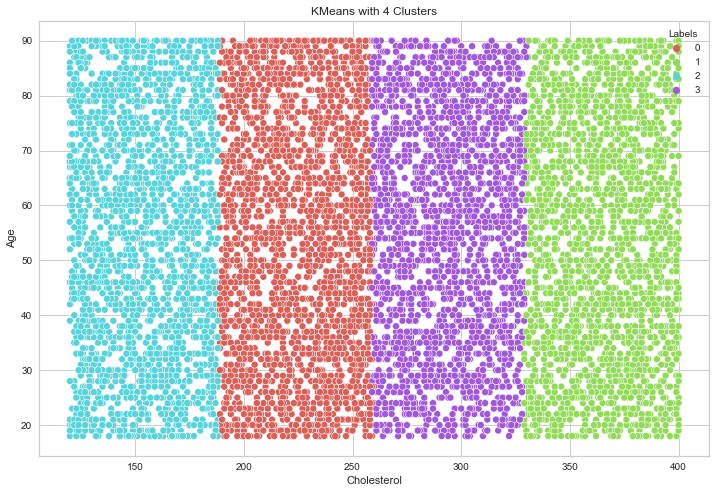

In [102]:
# 4 Cluster
km3 = KMeans(n_clusters = 4).fit(X)

X2['Labels'] = km3.labels_
plt.figure(figsize=(12, 8))
sns.scatterplot(data = X2, x= 'Cholesterol', y = 'Age', hue = X2['Labels'],
                palette = sns.color_palette('hls', 4))

plt.title('KMeans with 4 Clusters')
plt.show()

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
df